# 2D MEP Inversion
## Forward beregninger til at finde en olietank i 1,4 meters dybde med pyGimli 
### Formål
Avnø Højskole har en olietank et sted på deres grund, omkring 1,4 meter nede. Den skal findes med henblik på at lave miljøundersøgelser af jorden for at vurdere om og hvor meget der ville skulle fjernes hvis der potentielt skulle laves køkkenhave. 
Følgende er en undersøgelse af MEP som metode med udgangspunkt i Avnø's grund, pyGimli og tilgængelige ressourcer generelt

#### Data
På Jupiter ligger der en boreraport fra fra 1936
DGUnr 225. 10B der siger følgende 
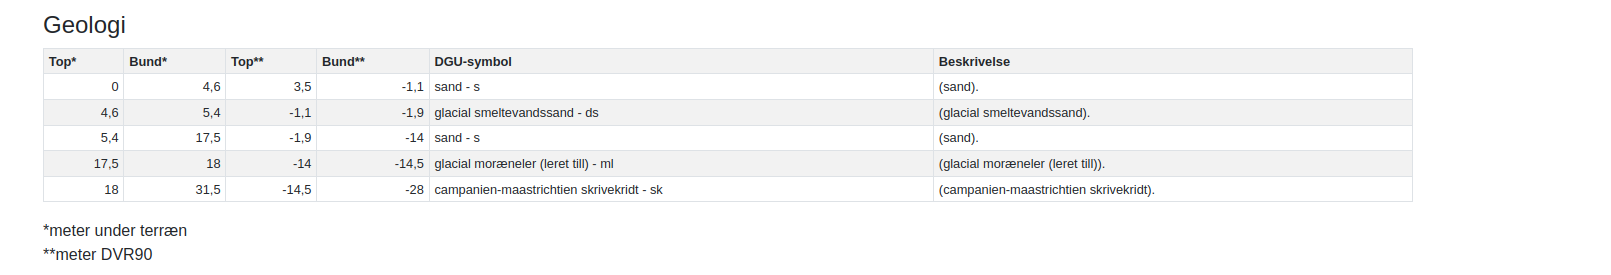
ud fra den laves nu en terori om hvad en måling i grunden vil vise. 

Her er en tabel over jorbundstyper i danmark


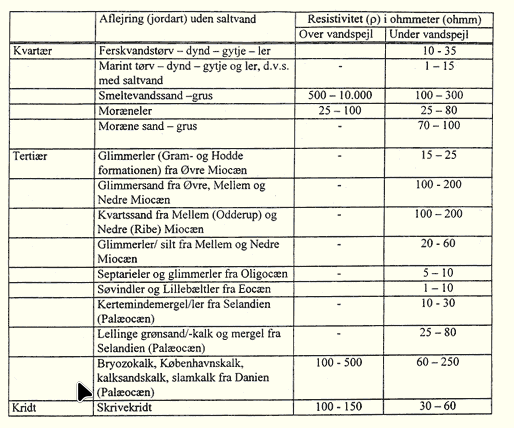
kilde: https://www2.mst.dk/udgiv/publikationer/2001/87-7944-826-7/html/bred01.htm


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert
import inspect

### Model 
Fra pyGimli tutorialen plot_01_ert_2d_mod_inv.ipynb "Create geometry definition for the modelling domain. ``worldMarker=True``
indicates the default boundary conditions for the ERT"
Koterne fra boredatabladet på området skrives ind i createWorld python klassen.
Her laves en model på 40 meter.

In [4]:
world = mt.createWorld(start=[-20, 0], end=[20, 0], layers=[3.5,-1.1,-1.9,-14,-29],
                        worldMarker=True)

In [5]:
tank = mt.createRectangle(
start=[-5, -1.4], end=[5, -4.0]) 

Vi lægger de to meshtools modeller sammen 
"Piecewise Linear Complex (PLC)"


In [6]:
geom = tank + world

(<Axes: >, None)

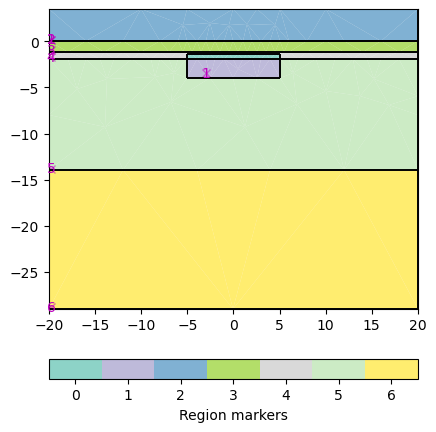

In [7]:
#print(inspect.getsource(pg.show))
geom.boundarySizes()

pg.show(geom )

## Apriori måleskema
Et dipol-dipol måleskema laves ('dd') med 21 elektroder.



In [8]:
scheme = ert.createData(elecs=np.linspace(start=-10, stop=10, num=4),
                           schemeName='dd')

## Resistivitet
"Put all electrode (aka sensors) positions into the PLC to enforce mesh
refinement. Due to experience, its convenient to add further refinement
nodes in a distance of 10% of electrode spacing to achieve sufficient
numerical accuracy."


Der skal laves to modeller, da det ikke vides om tanken er af plastic eller stål

$$ \rho = \frac{RA}{L}$$

Først antages et stort homegent halvrum. Her opfører elektroner sig som følgende
$$ J(r) = \frac{I}{2\pi r²} $$

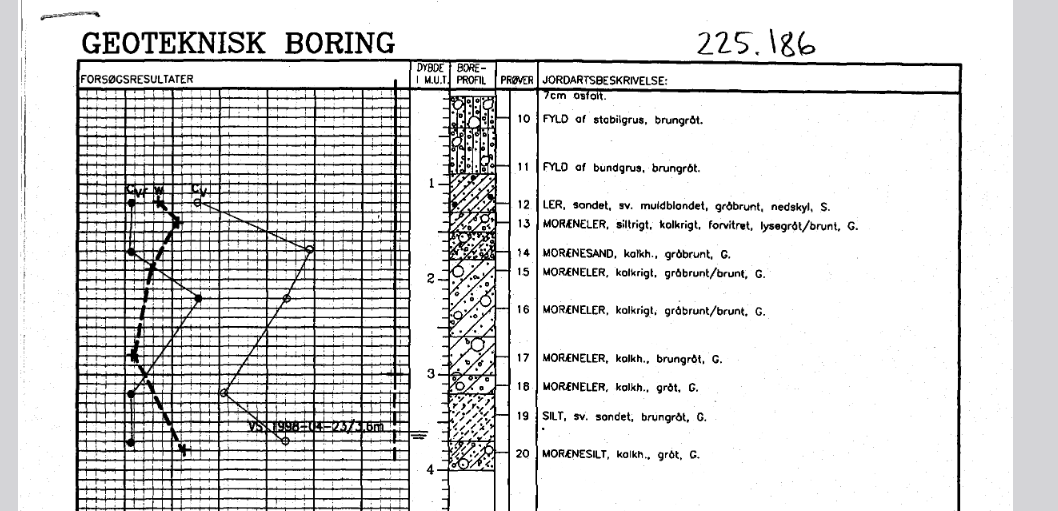






(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7f08f9281150>)

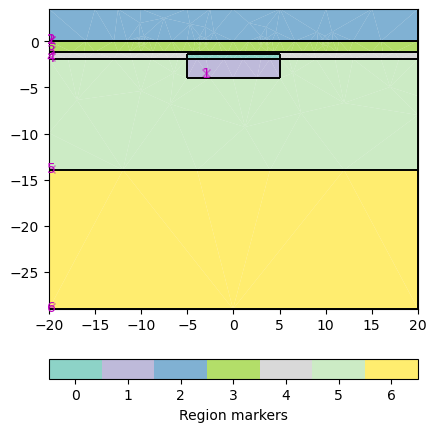

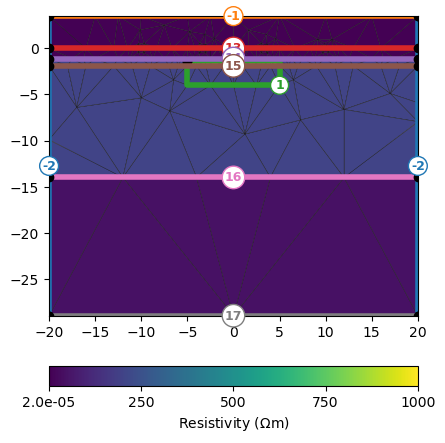

In [22]:
for p in scheme.sensors():
    geom.createNode(p)
    geom.createNode(p - [0, 0.1])

# Create a mesh for the finite element modelling with appropriate mesh quality.
mesh = mt.createMesh(geom, quality=340)

# Vi angiver ohm meter for de forskellige lag
# [[regionNumber, resistivity], [regionNumber, resistivity], [...]
rho = {'sand over vandspejlet':10e+2,'Vandmættet sand':200,'Glacial moræneler':3162, 'kalk':45,'stål':20e-6, 'plastic':10e+20}
rhomap = [ [0, rho["sand over vandspejlet"]],
           [1, rho["Vandmættet sand"]],
           [2, rho["stål"]],
           [3, rho["stål"]],
           [4, rho["Vandmættet sand"]],
           [5, rho["Vandmættet sand"]],
           [6, rho["kalk"]],
         ]
pg.show(geom, fitView=True)
# Take a look at the mesh and the resistivity distribution
pg.show(mesh, data=rhomap, label=pg.unit('res'), showMesh=True, fitView=True, regionMarker=False, boundaryMarkers=True )

"Perform the modelling with the mesh and the measuring scheme itself
and return a data container with apparent resistivity values,
geometric factors and estimated data errors specified by the noise setting.
The noise is also added to the data. Here 1% plus 1µV.
Note, we force a specific noise seed as we want reproducable results for
testing purposes."


In [19]:
data = ert.simulate(mesh, scheme=scheme, res=rhomap, noiseLevel=1,
                    noiseAbs=1e-6, seed=1337)

pg.info(np.linalg.norm(data['err']), np.linalg.norm(data['rhoa']))
pg.info('Simulated data', data)
pg.info('The data contains:', data.dataMap().keys())

pg.info('Simulated rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))
pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)

22/06/24 - 10:43:59 - pyGIMLi - INFO - Data error estimate (min:max)  4.515533094590412 : 4.515533094590412
22/06/24 - 10:43:59 - pyGIMLi - INFO - 4.515533094590412 6.0670275316145594e-05
22/06/24 - 10:43:59 - pyGIMLi - INFO - Simulated data Data: Sensors: 4 data: 1, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']
22/06/24 - 10:43:59 - pyGIMLi - INFO - The data contains: ['a', 'b', 'err', 'i', 'ip', 'iperr', 'k', 'm', 'n', 'r', 'rhoa', 'u', 'valid']
22/06/24 - 10:43:59 - pyGIMLi - INFO - Simulated rhoa (min/max) -6.0670275316145594e-05 -6.0670275316145594e-05
22/06/24 - 10:43:59 - pyGIMLi - INFO - Selected data noise %(min/max) 451.55330945904126 451.55330945904126


ModellingBase::setMesh() copying new mesh ... Found datafile: 4 electrodes
Found: 4 free-electrodes
relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
rMin = 3.33333, rMax = 40
NGauLeg + NGauLag for inverse Fouriertransformation: 6 + 4
Found non-Neumann domain
0.00173273 s
FOP updating mesh dependencies ... 1.527e-06 s
Calculating response for model: min = 2e-05 max = 1000
Allocating memory for primary potential...... 2.2604e-05

No primary potential for secondary field calculation. Calculating analytically...
Forward: time: 0.0138676s
Response: min = 2.78219e-05 max = 2.78219e-05 mean = 2.78219e-05
Reciprocity rms(modelReciprocity) 0.495607%, max: -0.495607%


Optional: you can filter all values and tokens in the data container.
Its possible that there are some negative data values due to noise and
huge geometric factors. So we need to remove them.



In [20]:
data.remove(data['rhoa'] < 0)
pg.info('Filtered rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))

# You can save the data for further use
data.save('simple.dat')

# You can take a look at the data
ert.show(data)

ValueError: min() arg is an empty sequence

## Inversion with the ERTManager
Initialize the ERTManager, e.g. with a data container or a filename.



In [23]:
mgr = ert.ERTManager('simple.dat')

Run the inversion with the preset data. The Inversion mesh will be created
with default settings.



In [24]:
inv = mgr.invert(lam=20, verbose=True)
np.testing.assert_approx_equal(mgr.inv.chi2(), 0.7, significant=1)

22/06/24 - 11:13:08 - pyGIMLi - INFO - Found 2 regions.
22/06/24 - 11:13:08 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
22/06/24 - 11:13:08 - pyGIMLi - INFO - Found 2 regions.
22/06/24 - 11:13:08 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
22/06/24 - 11:13:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
22/06/24 - 11:13:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
22/06/24 - 11:13:08 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 1112 Cells: 2076 Boundaries: 1630
22/06/24 - 11:13:08 - pyGIMLi - INFO - Use median(data values)=6.61398012824795
22/06/24 - 11:13:08 - pyGIMLi - INFO - Created startmodel from forward operator: 335, min/max=6.613980/6.613980
22/06/24 - 11:13:08 - pyGIMLi - INFO - Starting inversion.


Constructing Delaunay triangulation by divide-and-conquer method.
Delaunay milliseconds:  0
Recovering segments in Delaunay triangulation.
Segment milliseconds:  0
Removing unwanted triangles.
Spreading regional attributes and area constraints.
Hole milliseconds:  0
Adding Steiner points to enforce quality.
Quality milliseconds:  0

Writing vertices.
Writing triangles.
Writing segments.
Writing edges.

Output milliseconds:  0
Total running milliseconds:  0

Statistics:

  Input vertices: 49
  Input segments: 50
  Input holes: 0

  Mesh vertices: 297
  Mesh triangles: 519
  Mesh edges: 815
  Mesh exterior boundary edges: 73
  Mesh interior boundary edges: 17
  Mesh subsegments (constrained edges): 90

min/max(dweight) = 0.718638/99.9979
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x7f08f93f9f30>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x7f08f93fb650>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x7f08f93fa1b0>
min/max (data): 0.01/90

AssertionError: 
Items are not equal to 1 significant digits:
 ACTUAL: 103.03240009448375
 DESIRED: 0.7

Let the ERTManger show you the model of the last successful run and how it
fits the data. Shows data, model response, and model.



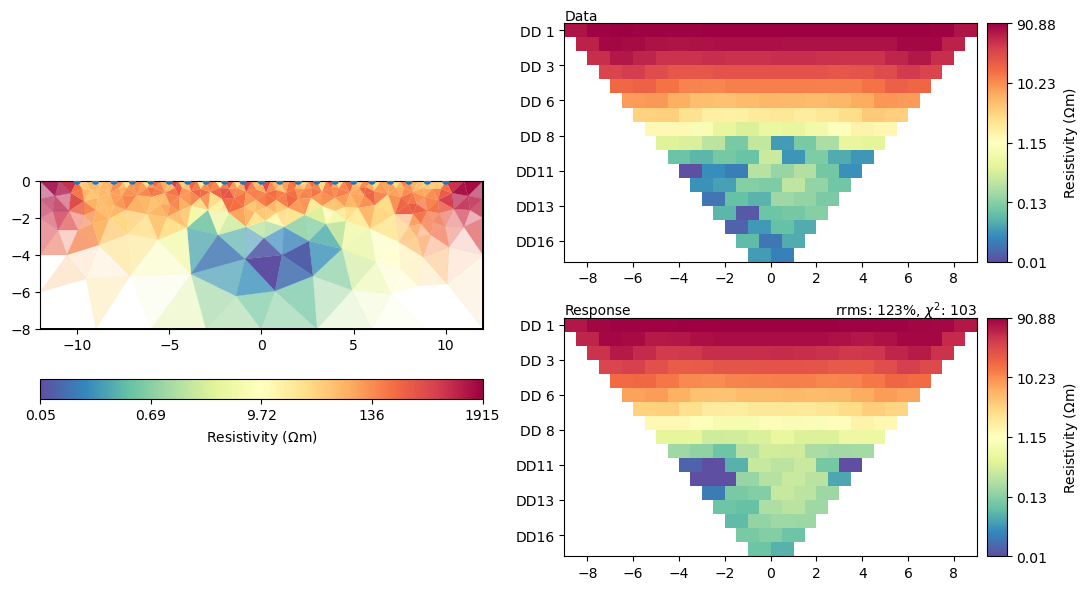

In [25]:
mgr.showResultAndFit()
meshPD = pg.Mesh(mgr.paraDomain) # Save copy of para mesh for plotting later

You can also provide your own mesh (e.g., a structured grid if you like them)
Note, that x and y coordinates needs to be in ascending order to ensure that
all the cells in the grid have the correct orientation, i.e., all cells need
to be numbered counter-clockwise and the boundary normal directions need to
point outside.



In [26]:
inversionDomain = pg.createGrid(x=np.linspace(start=-18, stop=18, num=33),
                                y=-pg.cat([0], pg.utils.grange(0.5, 8, n=5))[::-1],
                                marker=2)

## Inversion with custom mesh
The inversion domain for ERT problems needs a boundary that represents the
far regions in the subsurface of the halfspace.
Give a cell marker lower than the marker for the inversion region, the lowest
cell marker in the mesh will be the inversion boundary region by default.



(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7f08f882ba90>)

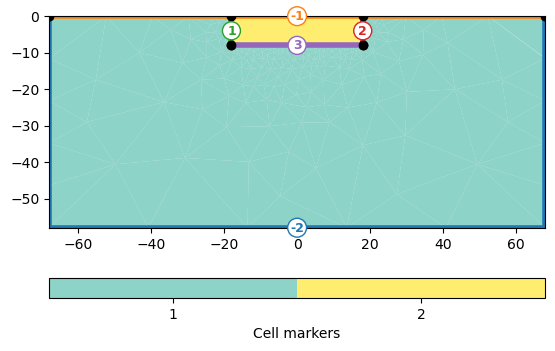

In [27]:
grid = pg.meshtools.appendTriangleBoundary(inversionDomain, marker=1,
                                           xbound=50, ybound=50)
pg.show(grid, markers=True)

The Inversion can be called with data and mesh as argument as well



In [59]:
model = mgr.invert(data, mesh=grid, lam=20, verbose=True)

30/05/24 - 22:18:01 - pyGIMLi - INFO - Found 2 regions.
30/05/24 - 22:18:01 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
30/05/24 - 22:18:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
30/05/24 - 22:18:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
30/05/24 - 22:18:01 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 1462 Cells: 2164 Boundaries: 1842
30/05/24 - 22:18:01 - pyGIMLi - INFO - Use median(data values)=14.472798520070278
30/05/24 - 22:18:01 - pyGIMLi - INFO - Created startmodel from forward operator: 160, min/max=14.472799/14.472799
30/05/24 - 22:18:01 - pyGIMLi - INFO - Starting inversion.


Found datafile: 21 electrodes
Found: 21 node-electrodes
Found non-Neumann domain
 updateDataDependency:: cleaning primpot
Reset region parameter
RegionManager copying mesh ...0.00272726 s 
create NeighborInfos ... 1.9617e-05 s 
analysing mesh ... 2 regions.
creating para domain ... 0.000706216 s
creating para domain ... 0.0016138 s
ModellingBase::setMesh() copying new mesh ... Found datafile: 21 electrodes
Found: 21 free-electrodes
Found non-Neumann domain
0.0183374 s
FOP updating mesh dependencies ... 1.2514e-05 s
ModellingBase::setMesh() copying new mesh ... 0.00676836 s
FOP updating mesh dependencies ... 2.0021e-05 s
min/max(dweight) = 54.5153/99.9961
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x7fe6d76b4c70>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x7fe6d7b81350>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x7fe6d7163ba0>
min/max (data): 0.49/144
min/max (error): 1%/1.83%
min/max (start model): 14.47/14.47
--------------------

## Visualization
You can of course get access to mesh and model and plot them for your own.
Note that the cells of the parametric domain of your mesh might be in
a different order than the values in the model array if regions are used.
The manager can help to permutate them into the right order.



In [29]:
modelPD = mgr.paraModel(model)  # do the mapping
pg.show(mgr.paraDomain, modelPD, label='Model', cMap='Spectral_r',
        logScale=True, cMin=25, cMax=150)

pg.info('Inversion stopped with chi² = {0:.3}'.format(mgr.fw.chi2()))

fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, sharey=True, figsize=(8,7))

pg.show(mesh, rhomap, ax=ax1, hold=True, cMap="Spectral_r", logScale=True,
        orientation="vertical", cMin=25, cMax=150)
pg.show(meshPD, inv, ax=ax2, hold=True, cMap="Spectral_r", logScale=True,
        orientation="vertical", cMin=25, cMax=150)
mgr.showResult(ax=ax3, cMin=25, cMax=150, orientation="vertical")

labels = ["True model", "Inversion unstructured mesh", "Inversion regular grid"]
for ax, label in zip([ax1, ax2, ax3], labels):
    ax.set_xlim(mgr.paraDomain.xmin(), mgr.paraDomain.xmax())
    ax.set_ylim(mgr.paraDomain.ymin(), mgr.paraDomain.ymax())
    ax.set_title(label)

NameError: name 'model' is not defined